# Anak Agung Ngurah Bagus Trihatmaja - DS5500
----------------------------------------------------------------------------------------------------

In [2]:
import pandas as pd
import numpy as np

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
import xgboost as xgb

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import  pyLDAvis.sklearn

from tqdm import tqdm
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import string

import matplotlib.pyplot as plt


# !python3 -m spacy download en_core_web_lg --user

In [3]:
nlp = spacy.load('en_core_web_lg')

In [4]:
data = pd.read_csv("./winemag-data_first150k.csv")

In [5]:
# We can see duplicated rows
data.loc[data["country"].isna()]

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
1133,1133,NaN,Delicate white flowers and a spin of lemon pee...,Askitikos,90,17.0,NaN,NaN,NaN,Assyrtiko,Tsililis
1440,1440,NaN,"A blend of 60% Syrah, 30% Cabernet Sauvignon a...",Shah,90,30.0,NaN,NaN,NaN,Red Blend,Büyülübağ
68226,68226,NaN,"From first sniff to last, the nose never makes...",Piedra Feliz,81,15.0,NaN,NaN,NaN,Pinot Noir,Chilcas
113016,113016,NaN,"From first sniff to last, the nose never makes...",Piedra Feliz,81,15.0,NaN,NaN,NaN,Pinot Noir,Chilcas
135696,135696,NaN,"From first sniff to last, the nose never makes...",Piedra Feliz,81,15.0,NaN,NaN,NaN,Pinot Noir,Chilcas


In [6]:
# Remove duplicate and NA
data = data[data.duplicated('description', keep=False)]
data = data.dropna(subset=['description', 'points', 'country', 'province', 'price'])

In [7]:
data.isna().sum()

Unnamed: 0         0
country            0
description        0
designation    25735
points             0
price              0
province           0
region_1       14453
region_2       46677
variety            0
winery             0
dtype: int64

In [8]:
# Remove variables, the Unnamed variable is just an index, the region_2 is mostly empty
data = data.drop(['Unnamed: 0', 'region_2'], axis=1)

In [9]:
# Fill NA
data = data.fillna(value={'designation': "EMPTY", 'region_1': "EMPTY"})

In [10]:
labels = data['points']
descriptions = data['description']

In [11]:
punctuations = string.punctuation
stopwords = list(STOP_WORDS)

In [12]:
# Parser for reviews
parser = English()
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [13]:
tqdm.pandas()
data["processed_description"] = data["description"].progress_apply(spacy_tokenizer)

100%|██████████| 83945/83945 [01:44<00:00, 801.00it/s] 


In [14]:
vectorizer = CountVectorizer(lowercase=True)
data_vectorized = vectorizer.fit_transform(data["processed_description"])

> Create 2 visualizations of different aspects of data to get a general understanding of its distribution. Explore correlations between different features, their distributions, etc. 

As we know the task here is to discover the pattern and get insight what can be useful as a feature

In [15]:
lda = LatentDirichletAllocation(n_components=10, doc_topic_prior=.01, max_iter=10, learning_method='online',verbose=True)
data_lda = lda.fit_transform(data_vectorized)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [16]:
pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne')
dash

/home/prdx/.local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
8      124.176414  196.951721       1        1  16.671307
1      -66.530525   78.536751       2        1  15.077722
9      -31.587551  -79.671104       3        1  12.441375
7      -62.098198  246.141052       4        1  11.911503
4      138.692993 -153.749054       5        1   9.590612
6       87.886673   29.571976       6        1   8.375717
3      252.030548   17.073914       7        1   7.817959
5     -204.455780  -87.913391       8        1   7.030641
2      -49.485767 -242.902725       9        1   6.542704
0     -231.704712  104.247932      10        1   4.540460, topic_info=      Category          Freq        Term         Total  loglift  logprob
term                                                                    
4945   Default  18218.000000         dry  18218.000000  30.0000  30.0000
14212  Default  13146.000000        spin  13146.000000  29.0000  29.0000
2493   Default   6491.000000    cabernet   6491.000000  28.0000  28.0000
1149   Default  18142.000000       aroma  18142.000000  27.0000  27.0000
6380   Default  39618.000000       fruit  39618.000000  26.0000  26.0000
1896   Default   8388.000000       blend   8388.000000  25.0000  25.0000
1847   Default  13571.000000       black  13571.000000  24.0000  24.0000
10908  Default  15453.000000      palate  15453.000000  23.0000  23.0000
15036  Default  17365.000000      tannin  17365.000000  22.0000  22.0000
1038   Default   7613.000000       apple   7613.000000  21.0000  21.0000
5936   Default  23896.000000      finish  23896.000000  20.0000  20.0000
3270   Default   7091.000000      citrus   7091.000000  19.0000  19.0000
8793   Default   6892.000000      little   6892.000000  18.0000  18.0000
11430  Default   5673.000000       pinot   5673.000000  17.0000  17.0000
3089   Default  23691.000000      cherry  23691.000000  16.0000  16.0000
1850   Default  11350.000000  blackberry  11350.000000  15.0000  15.0000
9531   Default   4172.000000      merlot   4172.000000  14.0000  14.0000
1760   Default  11987.000000       berry  11987.000000  13.0000  13.0000
11109  Default   6039.000000       peach   6039.000000  12.0000  12.0000
16996  Default   9010.000000        year   9010.000000  11.0000  11.0000
6022   Default  49672.000000      flavor  49672.000000  10.0000  10.0000
13235  Default   4859.000000   sauvignon   4859.000000   9.0000   9.0000
3164   Default   7462.000000   chocolate   7462.000000   8.0000   8.0000
16851  Default  51894.000000        wine  51894.000000   7.0000   7.0000
4091   Default   8255.000000       crisp   8255.000000   6.0000   6.0000
14199  Default  15527.000000       spice  15527.000000   5.0000   5.0000
10376  Default   9377.000000        nose   9377.000000   4.0000   4.0000
14891  Default  13493.000000       sweet  13493.000000   3.0000   3.0000
10468  Default  12416.000000         oak  12416.000000   2.0000   2.0000
8710   Default   7146.000000        like   7146.000000   1.0000   1.0000
...        ...           ...         ...           ...      ...      ...
235    Topic10    383.864756          30    384.752073   3.0898  -5.4607
4067   Topic10    363.505782       creek    364.393142   3.0897  -5.5152
871    Topic10    339.446052    american    340.333515   3.0895  -5.5837
7603   Topic10    310.165018   immediate    311.052421   3.0893  -5.6739
334    Topic10    282.678465          70    283.565766   3.0890  -5.7667
14428  Topic10    267.372463        step    268.259906   3.0888  -5.8223
2941   Topic10    244.975727       chalk    245.863254   3.0885  -5.9098
7018   Topic10    230.723053      ground    231.610437   3.0883  -5.9698
16177  Topic10    213.023336     usually    213.910717   3.0880  -6.0496
15556  Topic10    210.797098       trace    211.684540   3.0879  -6.0601
5353   Topic10    203.840666       equal    204.728028   3.0878  -6.0936
85     Topic10    202.091393          18    202.9

In here, we use LDA visualization (with TSNE) to show if our LDA is good as a dimensionality reduction of our text data. The plot is interactive with line and point as markers and size / area (for the point), length (for the bar), position, and color. The area covers the percentage of the token, while the position defines whether there are overlapping topic or not. Here we can see there is no overlapping topic. Which means our LDA is good.

(array([ 585., 2599., 5445., 7542., 4487., 3174., 1420.,  373.,   87.,
          23.]),
 array([ 80.,  82.,  84.,  86.,  88.,  90.,  92.,  94.,  96.,  98., 100.]),
 <a list of 10 Patch objects>)

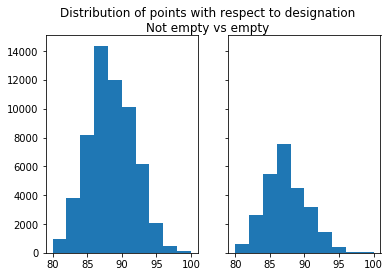

In [17]:
designation_not_empty = data[data['designation'] != "EMPTY"]
designation_empty =  data[data['designation'] == "EMPTY"]

fig, axs = plt.subplots(1, 2, sharey=True)
fig.suptitle("Distribution of points with respect to designation\nNot empty vs empty")
axs[0].hist(designation_not_empty['points'])
axs[1].hist(designation_empty['points'])

Here visualization is used to discover the distribution. We compare the distribution of points in respect of designation. We can see the distribution is the same, and only the size is different. However the number of missing values are quite many here. Thus we can decide to drop the variable as it might not be a good predictor. Here we use a simple plot from Matplotlib as a simple plot like this is sufficient to do the job. From the visualization perspective, we can see the marker being used are line, with position as a channel and the length as a channel. 

In [18]:
df = data

# We drop description because we don't need it anymore
# We drop points as it is the targetted variable and has been moved to labels
# We drop province and use country instead
# We drop designation as it has many missing values, and the distribution of the missing value is the same with the non missing value
df = df.drop(['description', 'province', 'points', 'designation'], axis=1)

In [19]:
# Transform to one-hot-vector
categorical_columns = ['country', 'region_1', 'variety', 'winery']
X = pd.get_dummies(df, columns=categorical_columns, sparse=True)

In [20]:
# Split training and testing
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

In [21]:
# Bag of words for training and testing
vectorizer = CountVectorizer(lowercase=True)
data_vectorized_train = vectorizer.fit_transform(X_train["processed_description"])
data_vectorized_test = vectorizer.transform(X_test["processed_description"])

In [22]:
# LDA as dimesionality reduction for train and testing
lda = LatentDirichletAllocation(n_components=10, doc_topic_prior=.01, max_iter=10, learning_method='online',verbose=True)
data_lda_train = lda.fit_transform(data_vectorized_train)
data_lda_test = lda.transform(data_vectorized_test)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [23]:
# Append LDA result to the dataframe
for i, d_train in enumerate(data_lda_train.T):
    X_train['topic_' + str(i)] = d_train

/home/prdx/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
# Append LDA result to the dataframe
for i, d_test in enumerate(data_lda_test.T):
    X_test['topic_' + str(i)] = d_test

/home/prdx/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
# Normalized price
scaler = StandardScaler()
X_train['price'] = scaler.fit_transform(np.array(X_train['price']).reshape(-1, 1))
X_test['price'] = scaler.transform(np.array(X_test['price']).reshape(-1, 1))

/home/prdx/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/prdx/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [26]:
# Not used anymore
X_train = X_train.drop(['processed_description'], axis=1)
X_test = X_test.drop(['processed_description'], axis=1)

In [27]:
# Split training and development
_X_train, X_dev, _y_train, y_dev = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [181]:
# Just a quick check with a model
test = RandomForestRegressor(max_depth=100)
test.fit(X_train, y_train)
test.score(X_test, y_test)

/home/prdx/.local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.892041706473874

---------------------------------------------------------------------------------------------------

In [28]:
X_dev_sparse = X_dev.to_sparse()

In [231]:
parameters = {'max_depth': [None, 10, 100], 'n_estimators': [500, 700, 1000]}

rf_cv = RandomizedSearchCV(RandomForestRegressor(), parameters, cv=10, scoring="r2", n_jobs=8, verbose=True)
rf_cv.fit(X_dev_sparse, y_dev)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


/home/prdx/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 127.2min
[Parallel(n_jobs=8)]: Done  90 out of  90 | elapsed: 282.0min finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=8,
          param_distributions={'max_depth': [None, 10, 100], 'n_estimators': [500, 700, 1000]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='r2', verbose=True)

In [234]:
# Memory problem, better save it before sorry
import pickle
with open("dump.p", "wb") as dump:
    pickle.dump(rf_cv, dump)

---------------------------------------------------------------------------------

In [ ]:
parameters = {'max_depth': [10, 100], 'n_estimators': [700, 1000]}

xgb_cv = RandomizedSearchCV(xgb.XGBRegressor(), parameters, cv=10, scoring="r2", 
                   n_jobs=1, verbose=1)
xgb_cv.fit(X_dev_sparse.as_matrix(), y_dev)

/home/prdx/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/home/prdx/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [ ]:
# Memory problem, better save it before sorry
with open("dump_2.p", "wb") as dump:
    pickle.dump(xgb_cv, dump)

---------------------------------------------------------------------------------

In [ ]:
parameters = {alpha=[1, 0.1, 0.01, 0.001]}
ridge_cv = RandomizedSearchCV(Ridge(), parameters, cv=10, scoring="r2", 
                   n_jobs=8, verbose=1)
ridge_cv.fit(X_dev_sparse, y_dev)

In [ ]:
# Memory problem, better save it before sorry
with open("dump_3.p", "wb") as dump:
    pickle.dump(ridge_cv, dump)

--------------------------------------------------------------------------------------------------

In [ ]:
file = open("dump.p",'rb')
loaded_cv = pickle.load(file)
file.close()

# Collecting the result
matrix = pd.DataFrame()

for i in range(10):
    col = list()
    col_name = "split" + str(i) + "_test_score"
    for j in range(0, 3):
        col.append(float("{0:.3f}".format(loaded_cv.cv_results_[col_name][j])))
    matrix[i] = col

matrix_np = matrix.as_matrix()

--------------------------------------------------------------------------------------------------------------------

In [ ]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go


plotly.offline.init_notebook_mode(connected=True)

In [ ]:
layout = go.Layout(
    title="Random Forest K-Fold CV Test Score with max depth=3 (default)",
    autosize=False,
    width=700,
    height=500,
    xaxis=go.layout.XAxis(
        title="Split"
    ),
    yaxis=go.layout.YAxis(
        title='R2 score',
        tickvals=[0.6, 0.7],
        range=[0.6, 0.7],
        tickmode='array',
        automargin=True
    )
)

trace1 = go.Scatter(
    x=np.arange(1,11),
    y=matrix_np[0],
    fill='tozeroy',
    mode= 'none',
    name="n_estimator=500"
)
trace2 = go.Scatter(
    x=np.arange(1,11),
    y=matrix_np[1],
    fill='tonexty',
    mode= 'none',
    name="n_estimator=700"
)
trace3 = go.Scatter(
    x=np.arange(1,11),
    y=matrix_np[2],
    fill='tonexty',
    mode= 'none',
    name="n_estimator=1000"
)

data = [trace1, trace2, trace3]
fig = dict(data=data, layout=layout)
py.iplot(fig)

In [ ]:
file = open("dump_2.p",'rb')
loaded_cv = pickle.load(file)
file.close()

# Collecting the result
matrix = pd.DataFrame()

for i in range(10):
    col = list()
    col_name = "split" + str(i) + "_test_score"
    for j in range(0, 3):
        col.append(float("{0:.3f}".format(loaded_cv.cv_results_[col_name][j])))
    matrix[i] = col

matrix_np = matrix.as_matrix()

In [ ]:
layout = go.Layout(
    title="XGBoost K-Fold CV Test Score with max depth=3",
    autosize=False,
    width=700,
    height=500,
    xaxis=go.layout.XAxis(
        title="Split"
    ),
    yaxis=go.layout.YAxis(
        title='R2 score',
        tickvals=[0.6, 0.7],
        range=[0.6, 0.7],
        tickmode='array',
        automargin=True
    )
)

trace1 = go.Scatter(
    x=np.arange(1,11),
    y=matrix_np[0],
    fill='tozeroy',
    mode= 'none',
    name="n_estimator=500"
)
trace2 = go.Scatter(
    x=np.arange(1,11),
    y=matrix_np[1],
    fill='tonexty',
    mode= 'none',
    name="n_estimator=700"
)
trace3 = go.Scatter(
    x=np.arange(1,11),
    y=matrix_np[2],
    fill='tonexty',
    mode= 'none',
    name="n_estimator=1000"
)

data = [trace1, trace2, trace3]
fig = dict(data=data, layout=layout)
py.iplot(fig)

In [ ]:
file = open("dump_3.p",'rb')
loaded_cv = pickle.load(file)
file.close()

# Collecting the result
matrix = pd.DataFrame()

for i in range(10):
    col = list()
    col_name = "split" + str(i) + "_test_score"
    for j in range(0, 3):
        col.append(float("{0:.3f}".format(loaded_cv.cv_results_[col_name][j])))
    matrix[i] = col

matrix_np = matrix.as_matrix()

There are three components we want to visualize. The first one is the parameter n_estimator, the second one is the split, and the third one is the r^2 score. Since we also want to show the trend, then it make sense to make it as a area chart. The channel is the area to show the value, the position to show the split, and the color to show the hyperparameter being tuned. Using plotly we can make it interactive thus we can also show the annotation.

-------------------------------------------------------------------------------------

In [ ]:
# Running model from the best result

rf = RandomForestRegressor(n_estimators=700)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

In [ ]:
# Running model from the best result

xgbr = xgb.XGBRegressor(n_estimators=700)
xgbr.fit(X_train.as_matrix(), y_train)

In [ ]:
# Running model from the best result

ridge = Ridge(alpha=xxx)
ridge.fit(X_train, y_train)
ridge.score(X_test, y_test)

----------------------------------------------------------------------------------------